# Exercises
- These exercises should go in a notebook or script named explore.

- Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

    - How many different cases are there, by department?
    - Does the percentage of cases that are late vary by department?
    - On average, how late are the late cases by department?
    - What is the service type that is the most late? Just for Parks & Rec?
    - For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
    - Does whether or not its a weekend matter for when a case is opened/closed?
    - On average, how many cases are opened a day for the Customer Service department?
    - Does the number of service requests for the solid waste department vary by day of the week?

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import wrangle

In [2]:
# Create a spark a session
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# 1. How many different cases are there, by department?

In [3]:
#acquire
df = wrangle.wrangle_311()

In [4]:
#Looking at first 5 values
df.show(5, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 1317                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
-RECORD 1-------------------------

In [5]:
#Get groupby department count
df.groupby("department").count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [6]:
#List of colors
color_list= ['lightcoral', 'turquoise', 'turquoise', 'turquoise', 'turquoise', 'turquoise', 'turquoise', 'turquoise']

Text(0.5, 0, 'Number of Cases')

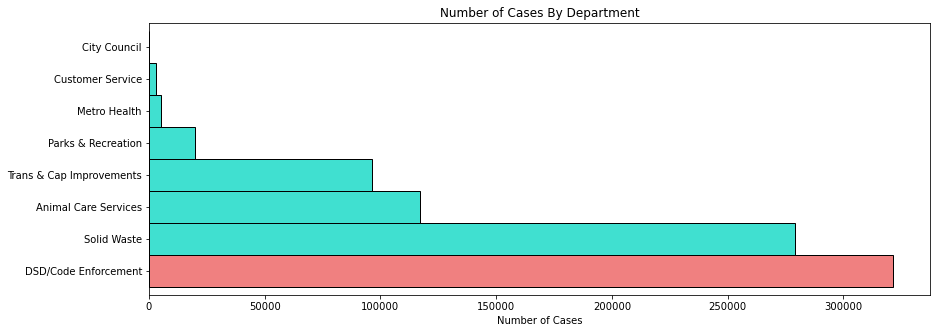

In [8]:
# First aggregate with spark
(
# group by    
    df.groupBy("department")
# aggregate by count    
    .count()
# then pass to pandas
    .toPandas()
# once its a dataframe, pass department as our index
    .set_index("department")["count"]
# sort our values for cleanliness of visualization
    .sort_values(ascending=False)
# pass our Series (department count values) to matplotlib
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5), color= color_list)
)

plt.title("Number of Cases By Department")
plt.ylabel(" ")
plt.xlabel("Number of Cases")

In [54]:
## Answer:
df.groupby("department").count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



# 2. Does the percentage of cases that are late vary by department?

In [9]:
#Looking at first 5 values
df.show(5, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 1317                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
-RECORD 1-------------------------

Text(0.5, 1.0, '% of Late Cases By Department')

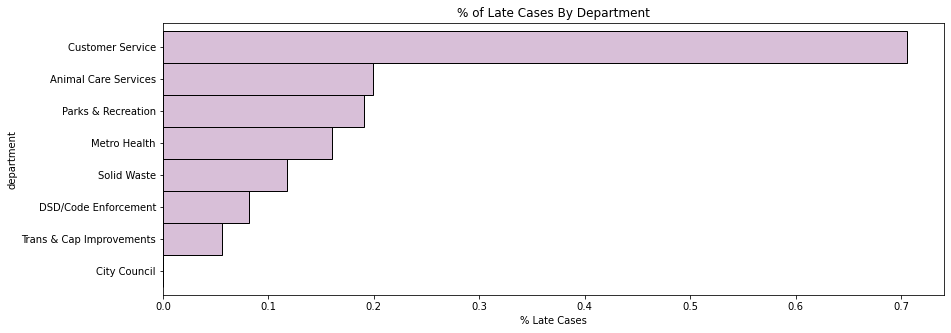

In [10]:
(
    df.withColumn("case_late", col("case_late").cast("int"))
    .groupby("department")
    .agg(avg("case_late").alias("probability_cases_late"))
    .toPandas()
    .set_index("department")
    .probability_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
)
plt.xlabel("% Late Cases")
plt.title("% of Late Cases By Department")

## Answer: Yes, the number of cases late do vary by Dept.

# 3. On average, how late are the late cases by department?

In [11]:
#Looking at columns and datatypes
df.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'timestamp'),
 ('case_closed_date', 'timestamp'),
 ('case_due_date', 'timestamp'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string'),
 ('num_weeks_late', 'double'),
 ('zipcode', 'string'),
 ('case_age', 'int'),
 ('days_to_closed', 'int'),
 ('case_lifetime', 'int'),
 ('department', 'string'),
 ('dept_subject_to_SLA', 'boolean')]

Text(0.5, 1.0, 'Avg Number of Weeks Late By Department')

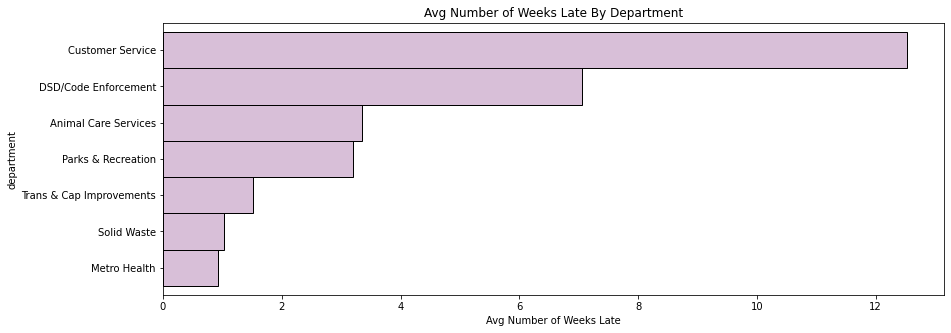

In [12]:
(
    df.where('case_late')
    .groupby("department")
    .agg(avg("num_weeks_late").alias("weeks_cases_late"))
    .toPandas()
    .set_index("department")
    .weeks_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
)
plt.xlabel("Avg Number of Weeks Late")
plt.title("Avg Number of Weeks Late By Department")

## Answer:
- Average number of weeks late by department:
    - Customer Svc: 12-13 weeks
    - DSD/Code Enforcement: 7-8 weeks
    - Animal Care Svc: 3-3.5 weeks
    - Parks & Recreation: 3 weeks
    - Trans & cap improv.: 1-1.5 weeks
    - Solid waste: 1 week
    - Metro Health: slightly less than 1 week

# 4. What is the service type that is the most late? Just for Parks & Rec?

Text(0.5, 1.0, 'Avg Number of Days Late By Service Request Type')

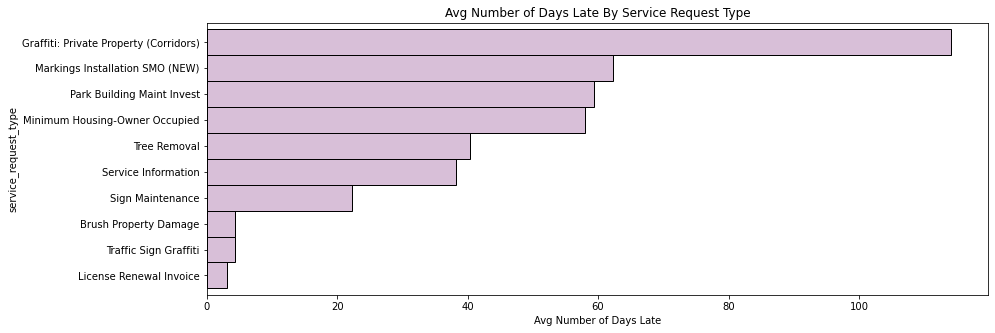

In [13]:
(
    df.where('case_late')
    .groupby("service_request_type")
    .agg(avg("num_days_late").alias("days_cases_late"))
    .limit(10)
    .toPandas()
    .set_index("service_request_type")
    .days_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
)
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Service Request Type")

## Answer: The service type that is most late is Graffiti and Markings Installation SMO (NEW).

Text(0.5, 1.0, 'Avg Number of Days Late By Service Request Type')

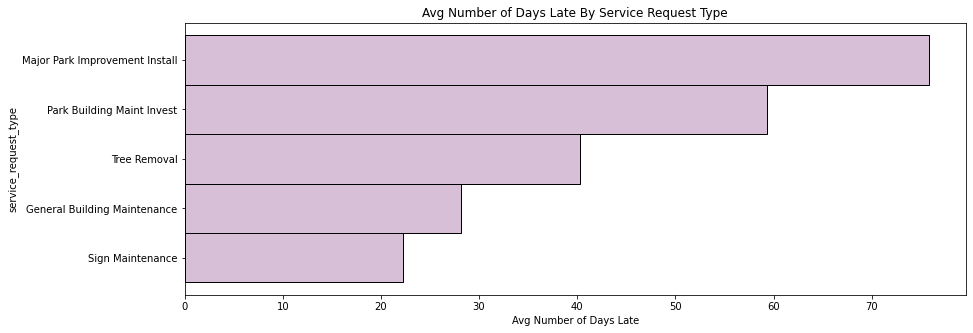

In [14]:
#Just for Parks and rec
(
    df.where('case_late').where(df.department=='Parks & Recreation')
    .groupby("service_request_type")
    .agg(avg("num_days_late").alias("days_cases_late"))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .days_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
)
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Service Request Type")

## Answer: For Parks and Rec the most common service that is late is Major Park Improvement Install.

# 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

Text(0.5, 1.0, 'Requests in DSD/Code Enforcement')

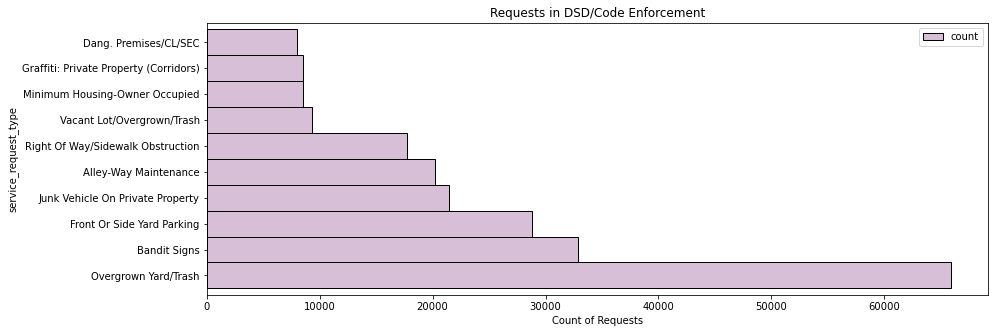

In [15]:
(
    df.where(expr('department=="DSD/Code Enforcement"'))
    .groupby("service_request_type")
    .count()
    .sort(desc('count'))
    .limit(10)
    .toPandas()
    .set_index("service_request_type")
    .plot.barh(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
)
plt.xlabel("Count of Requests")
plt.title("Requests in DSD/Code Enforcement")

## Answer: Most common service type is overgrown yard/trash.

# 6. Does whether or not its a weekend matter for when a case is opened/closed?

In [16]:
#Creating new weekday column for cases open
df = df.withColumn("week_day_name", date_format("case_opened_date", "E"))

In [17]:
#looking at first 5 values after adding weekday column
df.show(5, vertical= True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 1317                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 week_day_name        | Mon       

Text(0.5, 1.0, 'Cases Opened by Weekday')

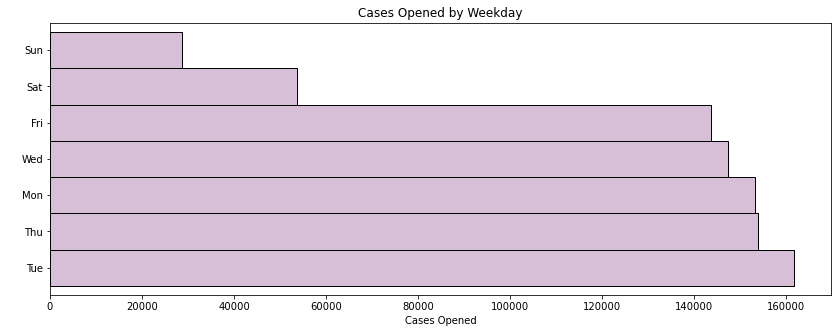

In [18]:
#cases open

(
    df.groupby('week_day_name')
    .count()
    .sort(desc('count'))
    .toPandas()
    .set_index('week_day_name')['count']
    .plot.barh(width=1, edgecolor='black', color='thistle', figsize= (14,5))
    
)

plt.xlabel('Cases Opened')
plt.ylabel(" ")
plt.title('Cases Opened by Weekday')

In [19]:
#Creating new weekday column for cases closed
df = df.withColumn("week_day_name_closed", date_format("case_closed_date", "E"))

Text(0.5, 1.0, 'Cases Closed by Weekday')

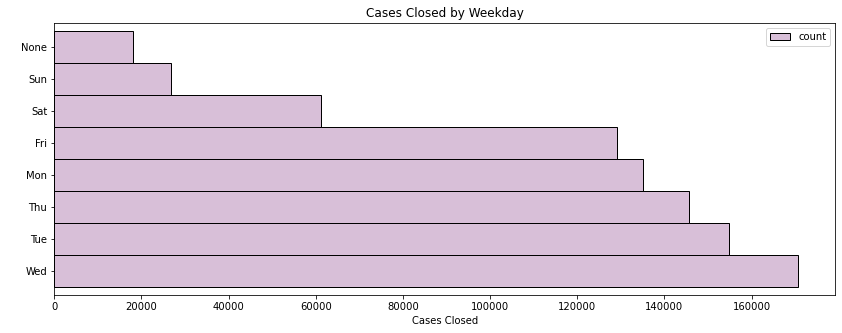

In [20]:
#day of the week case was closed
(
    df.groupBy("week_day_name_closed")
    .count()
    .sort(desc('count'))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("week_day_name_closed")
    .plot.barh(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
)

plt.xlabel("Cases Closed")
plt.ylabel(" ")
plt.title("Cases Closed by Weekday")

## Answer: For both open and closed cases there are less cases on the weekend (Sunday and Saturday).

# 7. On average, how many cases are opened a day for the Customer Service department?

In [21]:
#create new dataframe
num_cases = (
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()
)

In [22]:
#cases opened on average
num_cases.mean()

count    5.564453
dtype: float64

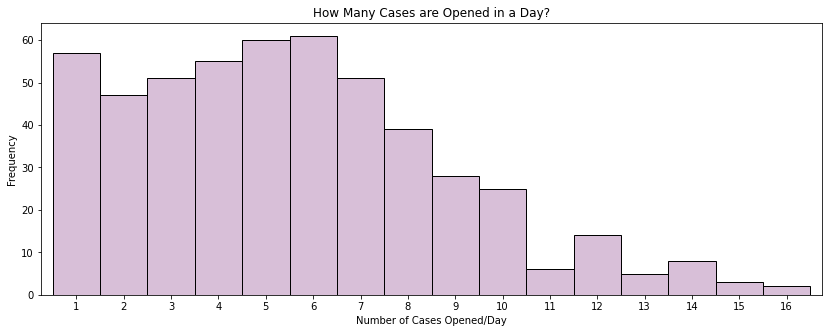

In [23]:
#visualize it
num_of_cases = num_cases['count']
mean_cases = num_of_cases.mean()
num_of_cases.value_counts().sort_index().plot.bar(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
plt.xlabel("Number of Cases Opened/Day")
plt.ylabel("Frequency")
plt.title("How Many Cases are Opened in a Day?")
plt.xticks(rotation=0)
plt.show()

## Answer: the number of cases opened on average is about 5 cases a day

# 8. Does the number of service requests for the solid waste department vary by day of the week?

In [24]:
#Looking at values counts of dataframe
df.groupBy("department").count().orderBy('department').show()

+--------------------+------+
|          department| count|
+--------------------+------+
|Animal Care Services|116915|
|        City Council|    33|
|    Customer Service|  2849|
|DSD/Code Enforcement|321374|
|        Metro Health|  5163|
|  Parks & Recreation| 19907|
|         Solid Waste|279270|
|Trans & Cap Impro...| 96193|
+--------------------+------+



In [31]:
#Looking at number of request by weekday in Solid waste department only
(df.where(df.department == 'Solid Waste')
    .groupby('service_request_type', 'week_day_name')
    .count().show())

+--------------------+-------------+-----+
|service_request_type|week_day_name|count|
+--------------------+-------------+-----+
|           No Pickup|          Wed|11828|
| Service Information|          Wed|   26|
|Request for Comme...|          Tue|   71|
|Organics Cart Rem...|          Wed|   33|
|Brush Partial Pic...|          Mon|   14|
|Recycle Container...|          Thu|    4|
|           No Pickup|          Thu|14372|
|Brush Missed Pick up|          Sun|   15|
|      Dial-A-Trailer|          Tue|    4|
|Additional Cart R...|          Thu|  548|
|      Cart Placement|          Sat|   24|
|Bulk Partial Pick Up|          Thu|    7|
|Organics Cart Rem...|          Tue|   24|
|Organics Info / L...|          Thu|  203|
|Disability Assist...|          Sat|  231|
|3rd Call Bagged L...|          Sat|    1|
|Additional Organi...|          Tue|    4|
|Disability Servic...|          Wed|  107|
|Solid Waste - Mis...|          Sun|   15|
|Brush_Received In...|          Tue|    1|
+----------

In [42]:
#Creating new dataframe with solid waste department only
sw_cases= (
    df.filter(df.department == 'Solid Waste')
    .groupby('service_request_type', 'week_day_name')
    .count()
    .sort(desc('count'))
    .toPandas()
)

In [43]:
sw_cases = sw_cases.groupby(['week_day_name']).mean()

In [53]:
sw_cases

,count
week_day_name,
Fri,948.203704
Mon,1117.019231
Sat,364.571429
Sun,191.250000
Thu,883.666667
Tue,1076.296296
Wed,822.490196


<AxesSubplot:xlabel='week_day_name'>

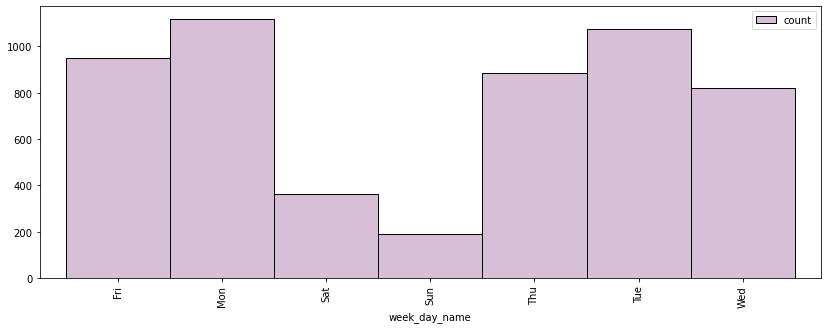

In [45]:
#Visualize it
sw_cases.plot.bar(width=1, edgecolor="black", color='thistle', figsize=(14, 5))

## Answer: The number of cases seems to decrease over the weekend (Saturday and Sunday)